# Visualization

The notebook contains examples for how the JSON output by Pangaea can be processed. Steps 2 & 3 require that the user has pathway information for a pathway of choice, but demonstrative data is provided in the package.


**1. Visualize interactions**

In this section, a demo JSON file is processed to show the interactions found in graph form.

**2. Recommended interactions not in an existing pathway**

Given data detailing interactions within a pathway, the JSON file can be used to recommend and rank interactions not found in the pathway.

**3. Show evidence found for each pathway**

Given pathway interactions, the JSON file may be used to show the amount of evidence that was obtained for each known interaction.

## 1. Visualize Interactions

### Data processing

For this section, the JSON data is processed in data that can later be used to build a graph. The nodes of the graphs are the genes and the edges are the relationships for each pair of genes. To achieve this, we select only the most popular types of interactions

In [1]:
%matplotlib inline

import json
import random
from collections import Counter, defaultdict
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

### Load data

In [2]:
root_dir = '../papers_parser/data/demo'

with open(os.path.join(root_dir, 'demo.json'), 'r') as f:
    data = json.load(f)

### Read relation type and genes involved

In [3]:
relations = []
for article in data:
    for relation in article['Relations']:
        relations.append((relation['Stems'], relation['Genes']))
        
print('First five relations stored: ')
pprint(relations[:5])

First five relations stored: 
[(['bind'], ['sema3a', 'pcdh9', 's100a3']),
 (['mutant', 'control'], ['smad4', 'tp53']),
 (['inhib'], ['fgfr2', 'fgfr1', 'fgfr3']),
 (['express'], ['set', 'ret', 'dicer1', 'braf', 'ntrk1', 'gc', 'tert']),
 (['interact'], ['brca2', 'brca1', 'atm', 'brip1', 'palb2', 'mlh1', 'fgfr3'])]


### Count number of interactions between each pair of genes for each type of interaction

In [4]:
d = defaultdict(lambda: defaultdict(int))
for rels, gene_list in relations:
    for i, g1 in enumerate(gene_list):
        for g2 in gene_list[i+1:]:
            for r in rels:
                d[r][frozenset([g1, g2])] += 1
                
                
print('Five pairs from the `interact` relationship type: ')
pprint(list(d['interact'].items())[:5])                

Five pairs from the `interact` relationship type: 
[(frozenset({'brca1', 'brca2'}), 5),
 (frozenset({'atm', 'brca2'}), 4),
 (frozenset({'brip1', 'brca2'}), 3),
 (frozenset({'brca2', 'palb2'}), 4),
 (frozenset({'mlh1', 'brca2'}), 2)]


### Keep only the 3 most common interaction types

In [5]:
n_rels = 3
rank_nodes = 40

l = []
for k, v in d.items():
    l.append([k, len(v)])
    
sorted_l = sorted(l, key=lambda elem: elem[1], reverse=True)[:n_rels]
selected_rels = [i[0] for i in sorted_l]

In [6]:
edge_colors = {k: v for k, v in zip(selected_rels, ['#9E9E9E', '#4A708B', '#8B3A62'])}

### Count the frequency of interactions for each gene (node) 

This will later be used to determine the size of the node in the graph.

In [7]:
nodes = defaultdict(int)
edges = defaultdict(list)
for k in selected_rels:
    selected = sorted(d[k].items(), key=lambda kv: kv[1], reverse=True)[:rank_nodes]
    for pair, freq in selected:
        edges[pair].append({'type': k, 'val': freq})
        for a in pair:
            nodes[a] += freq
        
print('Five genes along with their frequency of interactions:')
pprint(list(nodes.items())[:5])
print('\n')
print('Five interactions along with their frequency per type of interaction: ')
pprint(list(edges.items())[:5])

Five genes along with their frequency of interactions:
[('mmp2', 15), ('mmp9', 21), ('mir21', 12), ('mir18a', 10), ('laptm4bp2', 8)]


Five interactions along with their frequency per type of interaction: 
[(frozenset({'mmp2', 'mmp9'}), [{'type': 'express', 'val': 11}]),
 (frozenset({'mir21', 'mir18a'}), [{'type': 'express', 'val': 8}]),
 (frozenset({'laptm4bp2', 'laptm4b'}), [{'type': 'express', 'val': 8}]),
 (frozenset({'trim28', 'magec2'}), [{'type': 'express', 'val': 7}]),
 (frozenset({'s100a1', 's100a14'}),
  [{'type': 'express', 'val': 7}, {'type': 'associat', 'val': 3}])]


### Filter interactions such that only the dominant type of interaction for each pair is preserved

This will be used to decide on the color of the edge in graph.

In [8]:
edges_processed = {}
for pair, links in edges.items():
    vals = 0
    temp_max = 0
    for link in links:
        vals += link['val']
        if link['val'] > temp_max:
            temp_max = link['val']
            dominant_type = link['type']
    edges_processed[pair] = {'type': dominant_type, 'val': vals}


print('Five edges with their dominant interaction type')
pprint(list(edges_processed.items())[:5])

Five edges with their dominant interaction type
[(frozenset({'mmp2', 'mmp9'}), {'type': 'express', 'val': 11}),
 (frozenset({'mir21', 'mir18a'}), {'type': 'express', 'val': 8}),
 (frozenset({'laptm4bp2', 'laptm4b'}), {'type': 'express', 'val': 8}),
 (frozenset({'trim28', 'magec2'}), {'type': 'express', 'val': 7}),
 (frozenset({'s100a1', 's100a14'}), {'type': 'express', 'val': 10})]


### Create the Graph

In [9]:
G = nx.Graph()

for node_name, node_size in nodes.items():
    G.add_node(node_name.upper(), size=node_size)
    
for pair, props in edges_processed.items():
    pair = list(pair)
    G.add_edge(pair[0].upper(), pair[1].upper(), weight=props['val'], color=edge_colors[props['type']], label=props['type'])
    

In [10]:
names = {
    'express': 'Expression',
    'associat': 'Association',
    'target': 'Target',
}

### Plot the graph

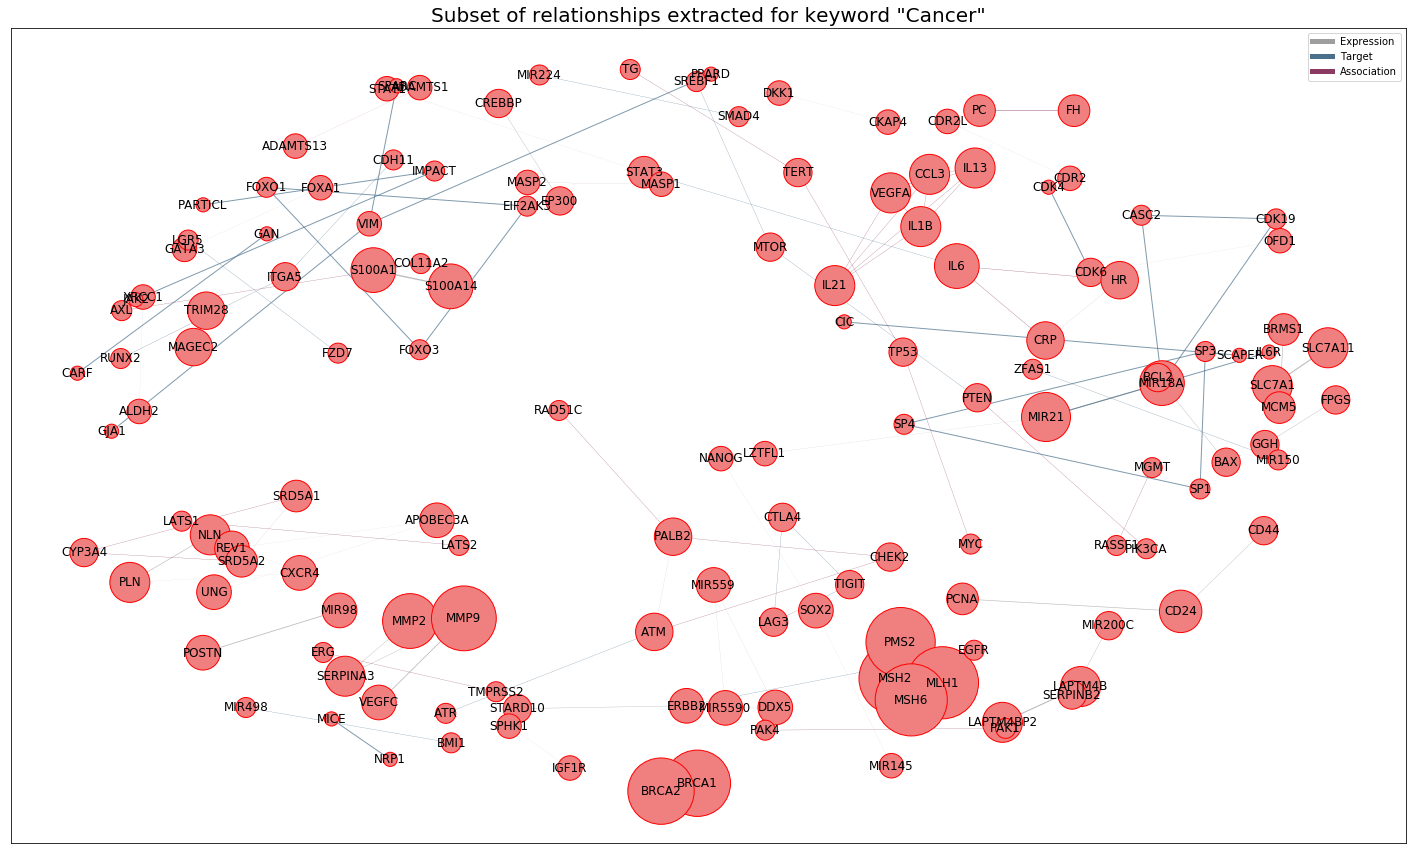

In [11]:
plt.figure(figsize=(25, 15))

# Extract attributes
sizes = [G.nodes[name]['size'] * 200 for name in G]
edge_col = [G[u][v]['color'] for u,v in G.edges()]
weights = [np.log(G[u][v]['weight']) - 1 for u,v in G.edges()]
node_color = '#F08080'

# Generate node positions
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw graph
nx.draw_networkx_nodes(G, node_color=node_color, node_size=sizes, pos=pos, edgecolors='r', with_labels=True)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos, width=weights, edge_color=edge_col, alpha=0.7)

# Generate legend
create_lines = lambda clr, **kwargs: Line2D([0, 1], [0, 1], color=clr, **kwargs)
lines = [create_lines(clr, lw=5) for clr in edge_colors.values()]
labels = [names[i] for i in edge_colors]

plt.title('Subset of relationships extracted for keyword "Cancer"', fontsize=20)
plt.legend(lines, labels)
plt.show()

### Write the graph in `graphml` format

In [12]:
from networkx.readwrite.graphml import write_graphml
write_graphml(G, 'cancer.graphml', encoding='utf-8', prettyprint=True, infer_numeric_types=False)

## 2. Recommended Interactions not in an Existing Pathway


### Load and process the JSON file

**NOTE**: This uses a different file than the one that is made available in the git repository. To provide a better idea of the results, we use a larger file that contains more interactions, but in git we only host a smaller file to avoid increasing download times for the repository.

In [13]:
with open(os.path.join(root_dir, 'interferon_demo.json'), 'r') as f:
    path_data = json.load(f)
    
path_d = defaultdict(list)
for article in path_data:
    for relation in article['Relations']:
        gene_list = relation['Genes']
        for i, g1 in enumerate(gene_list):
            for g2 in gene_list[i+1:]:
                if relation['Stems']:
                    path_d[frozenset([g1, g2])].append(relation['Stems'])
                    
print('Five examples of pairs of genes and their relationship types')
pprint(list(path_d.items())[3:8])                    

Five examples of pairs of genes and their relationship types
[(frozenset({'ifna1', 'ifnl2'}),
  [['associat', 'express'], ['associat', 'express']]),
 (frozenset({'ifna1', 'ifnl4'}),
  [['associat', 'express'], ['associat', 'express'], ['associat', 'funct']]),
 (frozenset({'ifna1', 'ifng'}),
  [['associat', 'express'],
   ['associat', 'express'],
   ['control'],
   ['regul'],
   ['regul', 'induc', 'inhib', 'target', 'express', 'pathway'],
   ['regul', 'control'],
   ['associat']]),
 (frozenset({'ifna1', 'ifnl1'}),
  [['associat', 'express'], ['associat', 'express']]),
 (frozenset({'ifna1', 'ifnb1'}),
  [['associat', 'express'],
   ['associat', 'express'],
   ['regul', 'induc', 'express'],
   ['phosphoryl', 'methyl', 'suppress'],
   ['regul', 'induc', 'inhib', 'target', 'express', 'pathway']])]


### Load pathway data

Processing data from https://www.wikipathways.org.

In [14]:
with open(os.path.join(root_dir, 'nodes.csv'), 'r') as f, open(os.path.join(root_dir, 'edges.csv'), 'r') as g:
    nodes = [row.split(',') for row in f.read().splitlines()]
    edges = [row.split(',') for row in g.read().splitlines()]

In [15]:
print('Five nodes from wikipathways data:')
pprint(nodes[:5])
print('\n')
print('Five edges from wikipathways data:')
pprint(edges[:5])

Five nodes from wikipathways data:
[['GAB2', 'Protein'],
 ['CRK', 'GeneProduct'],
 ['CBL', 'Protein'],
 ['RAPGEF1', 'Protein'],
 ['RPS6KB1', 'Protein']]


Five edges from wikipathways data:
[['STAT4', 'STAT4', 'mim-binding'],
 ['RPS6KA5', 'CREB1', 'Arrow'],
 ['PIK3R1', 'PIK3CD', 'Arrow'],
 ['CrkL', 'STAT5', 'Arrow'],
 ['CBL', 'CRKL', 'mim-binding']]


### Keep pairs that are not already in `edges.csv`

We want to recommend novel interactions, so among the interactions found, we eliminate those that are already in the pathway provided.

In [16]:
filtered = ['mouse', 'mice']
counter = {}

for gene_pair, rel_type in path_d.items():
    if any([gene in i for i in filtered for gene in gene_pair]):
        continue
    gene1, gene2 = gene_pair
    found = False
    for edge in edges:     
        pathway_genes = [e.lower() for e in edge][:2]
        if gene1 in pathway_genes and gene2 in pathway_genes:
            found = True
    if not found:
        counter[frozenset([gene1, gene2])] = [len(rel_type), Counter([i for j in rel_type for i in j]).most_common()[0][0]]

In [17]:
print('Five interaction pairs that are not in the pathway along with their most common type of interaction and frequency of interaction:')
list(counter.items())[:5]

Five interaction pairs that are not in the pathway along with their most common type of interaction and frequency of interaction:


[(frozenset({'rnase2', 'rnasel'}), [56, 'activ']),
 (frozenset({'rnasel', 'scaper'}), [3, 'translat']),
 (frozenset({'ifna1', 'ifnl2'}), [2, 'associat']),
 (frozenset({'ifna1', 'ifnl4'}), [3, 'associat']),
 (frozenset({'ifna1', 'ifng'}), [7, 'associat'])]

### Prepare data for display

In [18]:
candidate_rels = sorted(counter.items(), key=lambda kv: kv[1][0], reverse=True)
rank_data = []
filtered = ['il'] # Ignore genes containing these substrings
for candidate_rel, (score, common_rel) in candidate_rels:
    g1, g2 = candidate_rel
    if any(s in g.lower() for g in candidate_rel for s in filtered):
        continue
    rank_data.append(["{} - {} ({})".format(g1.upper(), g2.upper(), common_rel), score])

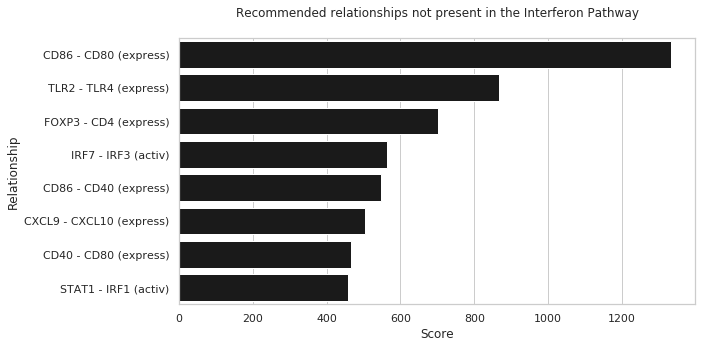

In [19]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10, 5))

sns.set(style='whitegrid')
rank_df = pd.DataFrame(rank_data, columns=['Relationship', 'Score'])
sns.barplot(x='Score', y='Relationship', data=rank_df.head(8), color='k')
plt.title('Recommended relationships not present in the Interferon Pathway\n')#, fontdict={'size': 17})
plt.tight_layout()

## 3. Show Evidence Found for each Pathway

Visualize the amount of evidence provided in the obtained JSON file for each interaction previously known in the pathway.

### Count evidence for each interaction

In [20]:
path_res = {}

for g1, g2, _ in edges:
    pair = frozenset([g1.lower(), g2.lower()])
    if len(pair) == 1:
        continue
    res = path_d.get(pair, None)
    if res:
        path_res[pair] = len(res)
    else:
        path_res[pair] = 0

In [21]:
print('Five pairs along with evidence (count) provided for each:')
list(path_res.items())[:5]

Five pairs along with evidence (count) provided for each:


[(frozenset({'creb1', 'rps6ka5'}), 0),
 (frozenset({'pik3cd', 'pik3r1'}), 0),
 (frozenset({'crkl', 'stat5'}), 8),
 (frozenset({'cbl', 'crkl'}), 11),
 (frozenset({'pik3r1', 'pik3r2'}), 0)]

### Create graph

In [22]:
nodes = set([a.upper() for i in path_res.keys() for a in i])

In [23]:
G = nx.Graph()

for node in nodes:
    G.add_node(node)
    
for (g1, g2), weight in path_res.items():
    G.add_edge(g1.upper(), g2.upper(), weight=weight)    

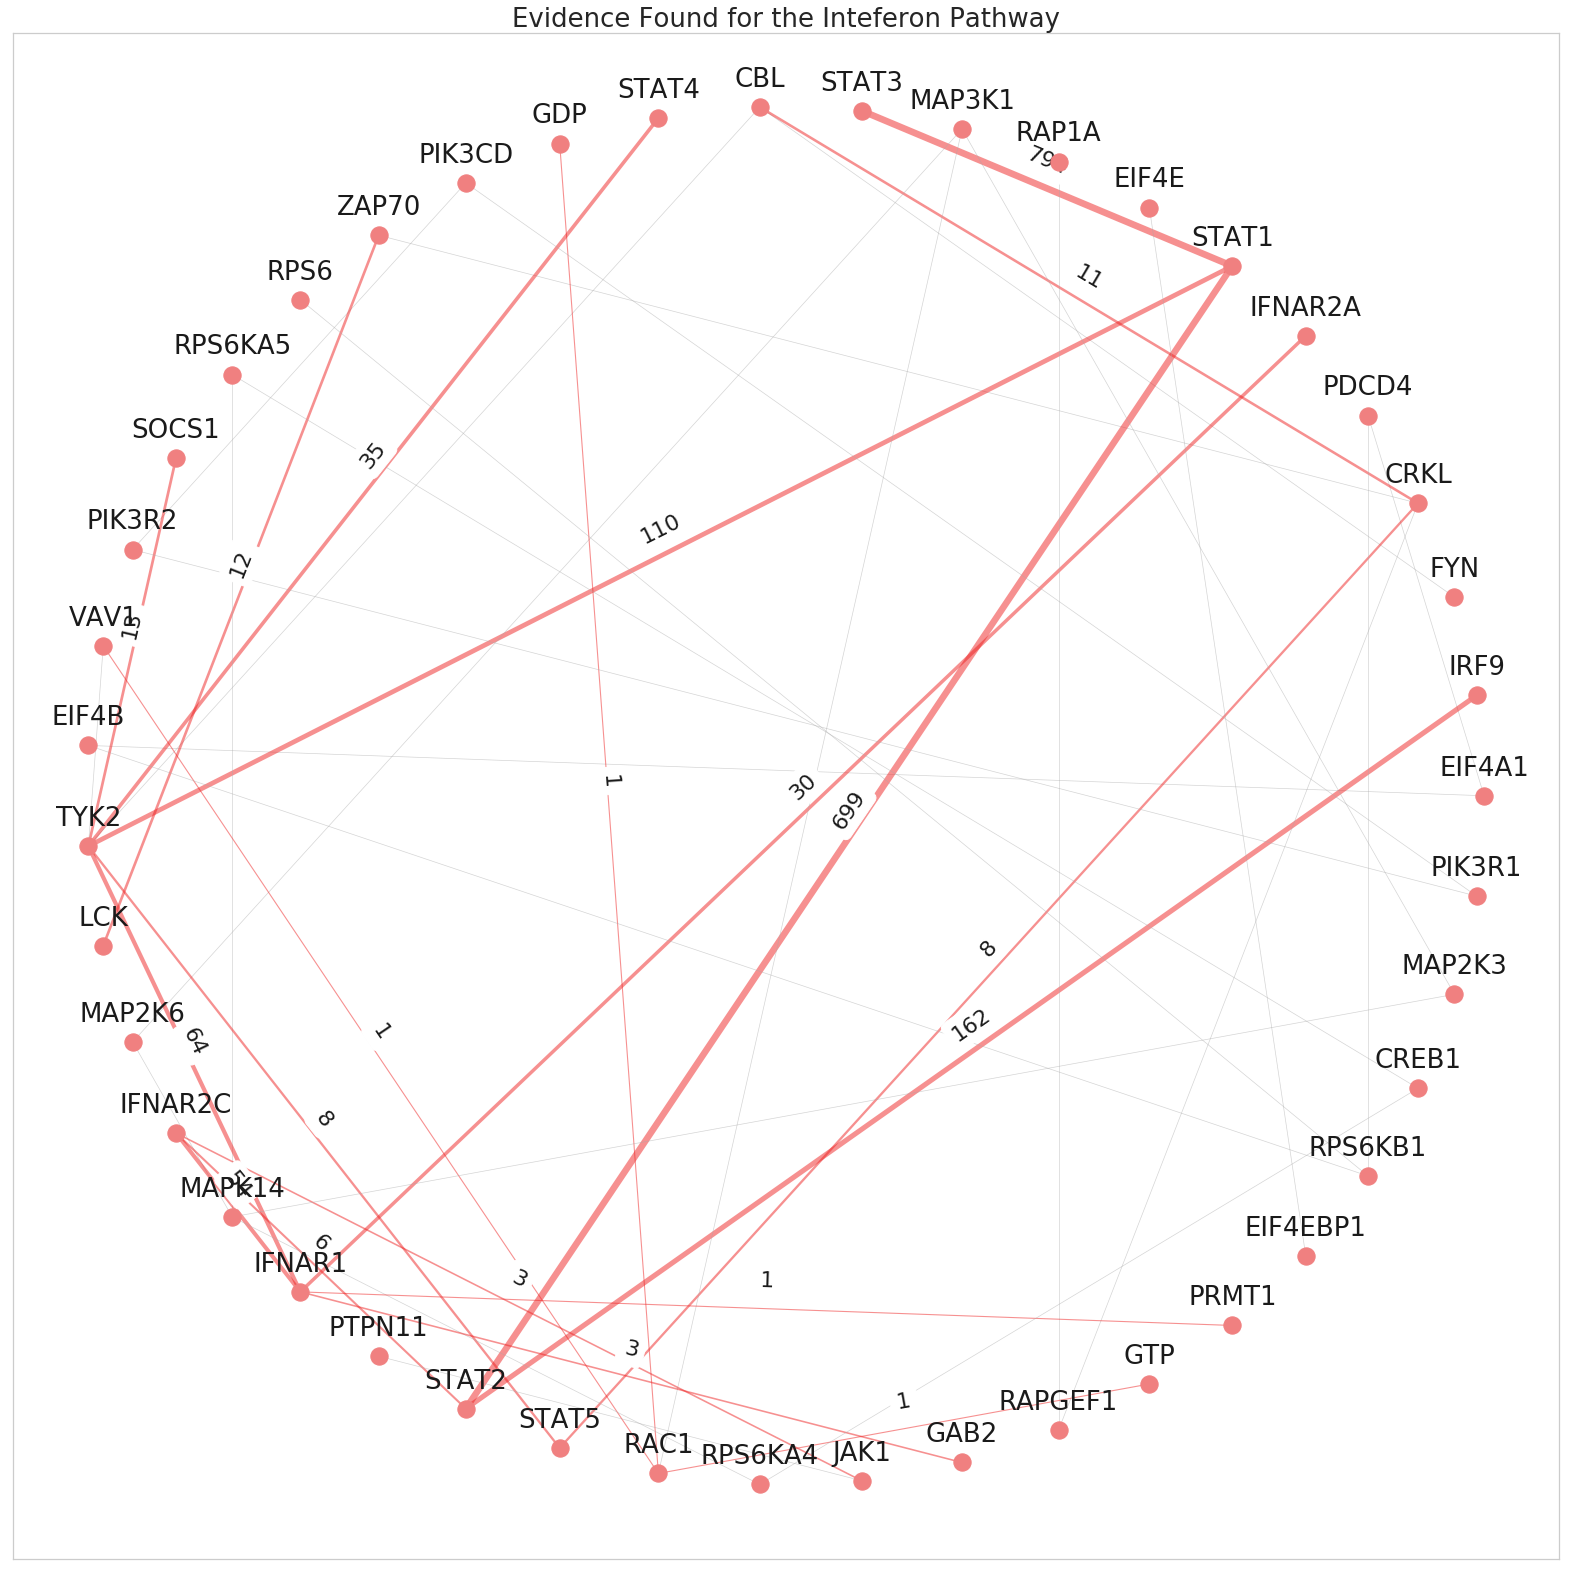

In [24]:
plt.figure(figsize=(22, 22))

weights = [np.log(G[u][v]['weight'] + 2) for u,v in G.edges()]
edge_col = [['#aaaaaa', '#ee2222'][G[u][v]['weight'] > 0] for u,v in G.edges()]
edge_labels = {k: v if v else '' for k, v in nx.get_edge_attributes(G,'weight').items()}
labels = [str(G[u][v]['weight']) for u,v in G.edges()]
pos = nx.circular_layout(G)

pos_higher = {}
y_off = 0.04  # offset on the y axis
for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)

nx.draw_networkx_nodes(G, pos=pos, node_color='#F08080', with_labels=True, width=2, weights=weights)
nx.draw_networkx_labels(G, pos=pos_higher, font_size=26, ont_family='DejaVu Sans Mono')
nx.draw_networkx_edges(G, pos=pos,  edge_color=edge_col, edgecolors='r', width=weights, alpha=0.5)
nx.draw_networkx_edge_labels(G, pos=pos_higher, edge_labels=edge_labels, font_size=22)

plt.title('Evidence Found for the Inteferon Pathway', fontdict={'size': 26})
plt.grid()
plt.tight_layout()
plt.show()

In [25]:
write_graphml(G, 'interferon.graphml', encoding='utf-8', prettyprint=True, infer_numeric_types=False)